In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# raw data pulled from the VSCS dashboard with the pivot table expanded to include the following columns:
# Offense Group: high level offense category (ASSAULT, ROBBERY, etc.)
# VCC: the offense code
# FiscalYr: the fiscal year in which the offender was sentenced
# ActDisp: sentencing disposition, type 2 indicates County Jail 3 indicates State Prison
# Category: 0, 1, 2, or 9 representing the crime severity (Category 1 and 2 are violent)
# effsent: the effective sentence in months
# Number of Events: number of sentencing events in this group

#raw_va_sentence_df = pd.read_csv('VA_data/unprocessed_va_historical_sentences.csv', sep='\t')

raw_va_sentence_df = pd.read_csv('VA_data/unprocessed_va_historical_sentences_v2.csv', sep='\t')

raw_va_sentence_df['offense_group'] = raw_va_sentence_df['Offense Group'].ffill()
raw_va_sentence_df['offense_code'] = raw_va_sentence_df['VCC'].ffill()
raw_va_sentence_df['off1_vcc'] = raw_va_sentence_df['Off1VCC'].ffill()
raw_va_sentence_df['judge_id'] = raw_va_sentence_df['JudgeID'].ffill()
raw_va_sentence_df['sentence_type_code'] = raw_va_sentence_df['ActDisp'].ffill()
raw_va_sentence_df['year'] = raw_va_sentence_df['FiscalYr'].ffill()
raw_va_sentence_df['effective_sentence_months'] = raw_va_sentence_df['effsent']
raw_va_sentence_df['effective_sentence_years'] = raw_va_sentence_df['effective_sentence_months']/12.0
raw_va_sentence_df['life_sentence'] = raw_va_sentence_df['EffLif']
raw_va_sentence_df['offense_date'] = raw_va_sentence_df['Off1Date']
raw_va_sentence_df['compartment'] = 'pretrial'

raw_va_sentence_df = raw_va_sentence_df[~raw_va_sentence_df['offense_group'].str.contains('Total')]

# convert the ActDisp numerical value into an incarceration type flag
act_disp_dict = {1: 'probation', 2: 'jail', 3: 'prison'}
raw_va_sentence_df['sentence_type'] = raw_va_sentence_df['sentence_type_code'].apply(lambda x: act_disp_dict[x])

# convert the offense category into violent/non-violent
# offence_category_dict = {0: 'non-violent', 1: 'violent', 2: 'violent', 9: 'non-violent'}
# raw_va_sentence_df['offense_category'] = raw_va_sentence_df['offense_category_code'].apply(
#     lambda x: offence_category_dict[x]
# )

# drop extra columns
raw_va_sentence_df = raw_va_sentence_df.drop(
    ['Offense Group', 'VCC', 'FiscalYr', 'ActDisp', 'effsent', 'JudgeID', 'sentence_type_code', 'Off1VCC', 'EffLif',
     'Off1Date'], 
    axis=1
)

print(len(raw_va_sentence_df))
raw_va_sentence_df.head()

74302


,OffLName,OffFName,offense_group,offense_code,off1_vcc,judge_id,year,effective_sentence_months,effective_sentence_years,life_sentence,offense_date,compartment,sentence_type
0,MOORE,KENNETH,ASSAULT,ASL1316,ASL1316F6,0,2018.0,18.0,1.500000,0.0,5/20/2017,pretrial,prison
1,CLINE,MATTHEW,ASSAULT,ASL1316,ASL1316F6,0,2019.0,10.0,0.833333,0.0,4/25/2018,pretrial,prison
2,TINSLEY,JAVON,ASSAULT,ASL1316,ASL1316F6,10DB,2018.0,0.0,0.000000,0.0,11/11/2017,pretrial,probation
3,COMPTON,ROBERT,ASSAULT,ASL1316,ASL1316F6,10DB,2017.0,0.0,0.000000,0.0,6/8/2015,pretrial,jail
4,MILLER,MARCUS,ASSAULT,ASL1316,ASL1316F6,10DB,2017.0,7.0,0.583333,0.0,12/25/2016,pretrial,prison


In [3]:
va_sentence_df = raw_va_sentence_df.drop(['OffLName', 'OffFName'], axis=1)
va_sentence_df.head()

,offense_group,offense_code,off1_vcc,judge_id,year,effective_sentence_months,effective_sentence_years,life_sentence,offense_date,compartment,sentence_type
0,ASSAULT,ASL1316,ASL1316F6,0,2018.0,18.0,1.500000,0.0,5/20/2017,pretrial,prison
1,ASSAULT,ASL1316,ASL1316F6,0,2019.0,10.0,0.833333,0.0,4/25/2018,pretrial,prison
2,ASSAULT,ASL1316,ASL1316F6,10DB,2018.0,0.0,0.000000,0.0,11/11/2017,pretrial,probation
3,ASSAULT,ASL1316,ASL1316F6,10DB,2017.0,0.0,0.000000,0.0,6/8/2015,pretrial,jail
4,ASSAULT,ASL1316,ASL1316F6,10DB,2017.0,7.0,0.583333,0.0,12/25/2016,pretrial,prison


In [4]:
# expand the DF to 1 row per sentence instead of 1 row per sentence type
## DEPRECATED BECAUSE OF NEW FILE FORMAT
expanded_sentence_level_list = []
non_expanded_columns = [col for col in raw_va_sentence_df.columns if col != 'total_sentences']
for index, row in raw_va_sentence_df.iterrows():
    row_dict = {}
    for col in non_expanded_columns:
        row_dict[col] = row[col]
    expanded_sentence_level_list.extend([row_dict] * int(row['total_sentences']))

va_sentence_df = pd.DataFrame(expanded_sentence_level_list)
print(len(va_sentence_df))
va_sentence_df.head()

74445


,offense_group,offense_code,year,offense_category_code,effective_sentence_months,effective_sentence_years,outflow_from,sentence_type,offense_category
0,ASSAULT,ASL1316,2017.0,0.0,0.0,0.0,pretrial,probation,non-violent
1,ASSAULT,ASL1316,2017.0,0.0,0.0,0.0,pretrial,probation,non-violent
2,ASSAULT,ASL1316,2017.0,0.0,0.0,0.0,pretrial,probation,non-violent
3,ASSAULT,ASL1316,2017.0,2.0,0.0,0.0,pretrial,probation,violent
4,ASSAULT,ASL1316,2017.0,9.0,0.0,0.0,pretrial,probation,non-violent


In [4]:
va_sentence_df['offense_group'].value_counts(dropna=False)

DRUG/SCHEDULE I/II        28433
LARCENY                   14966
FRAUD                      5285
ASSAULT                    4848
TRAFFIC FELONY             4649
DRUG OTHER                 3096
WEAPONS/FIREARMS           2523
BURGLARY/DWELLING          1899
ROBBERY                    1621
MISC/PERSON & PROPERTY     1416
MISC_OTHER                 1253
BURGLARY/OTHER             1022
OTHER SEXUAL ASSAULT        966
MURDER                      762
OBSCENITY                   649
RAPE                        523
KIDNAPPING                  391
Name: offense_group, dtype: int64

In [5]:
va_sentence_df['year'].value_counts(dropna=False)

2019.0    24990
2017.0    24666
2018.0    24646
Name: year, dtype: int64

In [6]:
raw_va_sentence_df['year'].value_counts(dropna=False)

2019.0    24990
2017.0    24666
2018.0    24646
Name: year, dtype: int64

In [7]:
raw_va_sentence_df['offense_group'].value_counts(dropna=False)

DRUG/SCHEDULE I/II        28433
LARCENY                   14966
FRAUD                      5285
ASSAULT                    4848
TRAFFIC FELONY             4649
DRUG OTHER                 3096
WEAPONS/FIREARMS           2523
BURGLARY/DWELLING          1899
ROBBERY                    1621
MISC/PERSON & PROPERTY     1416
MISC_OTHER                 1253
BURGLARY/OTHER             1022
OTHER SEXUAL ASSAULT        966
MURDER                      762
OBSCENITY                   649
RAPE                        523
KIDNAPPING                  391
Name: offense_group, dtype: int64

In [8]:
raw_va_sentence_df['EffLif'].value_counts(dropna=False)

KeyError: 'EffLif'

In [9]:
raw_va_sentence_df[raw_va_sentence_df['life_sentence'] == 1]['offense_group'].value_counts(dropna=False)

MURDER        65
RAPE          42
ASSAULT        4
KIDNAPPING     1
OBSCENITY      1
Name: offense_group, dtype: int64

In [10]:
# store the processed dataframe as a csv
raw_va_sentence_df.to_csv('VA_data/processed_va_historical_sentences_v2.csv', index=False)

In [33]:
raw_va_sentence_df[(raw_va_sentence_df[['OffFName', 'OffLName', 'Off1Date']].duplicated())]

,Off1Date,EffLif,OffLName,OffFName,offense_group,offense_code,off1_vcc,judge_id,sentence_type_code,year,effective_sentence_months,effective_sentence_years,outflow_from
83,8/5/2016,0.0,CURTIS,JAVON,ASSAULT,ASL1316,ASL1316F6,14JY,3.0,2017.0,30.000000,2.500000,pretrial
3209,11/12/2016,0.0,JOHNSON,RAYMOND,ASSAULT,ASL1342,ASL1342F6,15HH,3.0,2018.0,8.000000,0.666667,pretrial
3268,10/23/2015,0.0,RICHARDSON,BRIAN,ASSAULT,ASL1342,ASL1342F6,15VW,3.0,2017.0,34.000000,2.833333,pretrial
3357,11/20/2016,0.0,TRAYNHAM,DEON,ASSAULT,ASL1342,ASL1342F6,18ND,3.0,2017.0,20.000000,1.666667,pretrial
3526,5/4/2016,0.0,POWELL,CRYSTAL,ASSAULT,ASL1342,ASL1342F6,23CD,3.0,2017.0,9.971253,0.830938,pretrial
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73712,1/9/2016,0.0,RATCLIFF,SHAWN,WEAPONS/FIREARMS,WPN5297,WPN5297F6,2FL,3.0,2019.0,36.000000,3.000000,pretrial
73753,4/18/2018,0.0,MULLINS,STEVEN,WEAPONS/FIREARMS,WPN5297,WPN5297F6,30CD,3.0,2019.0,24.000000,2.000000,pretrial
73831,7/19/2016,0.0,HAIRSTON,JARELL,WEAPONS/FIREARMS,WPN5297,WPN5297F6,4JF,3.0,2018.0,24.000000,2.000000,pretrial
73940,12/5/2015,0.0,HARRIS,THOMAS,WEAPONS/FIREARMS,WPN5298,WPN5298F6,10DB,1.0,2017.0,0.000000,0.000000,pretrial


In [32]:
raw_va_sentence_df[(raw_va_sentence_df['OffFName'] == 'RAYMOND') & (raw_va_sentence_df['OffLName'] == 'JOHNSON')]

,Off1Date,EffLif,OffLName,OffFName,offense_group,offense_code,off1_vcc,judge_id,sentence_type_code,year,effective_sentence_months,effective_sentence_years,outflow_from
3206,11/12/2016,0.0,JOHNSON,RAYMOND,ASSAULT,ASL1342,ASL1342F6,15HH,3.0,2017.0,13.000000,1.083333,pretrial
3209,11/12/2016,0.0,JOHNSON,RAYMOND,ASSAULT,ASL1342,ASL1342F6,15HH,3.0,2018.0,8.000000,0.666667,pretrial
12338,5/26/2016,0.0,JOHNSON,RAYMOND,DRUG/SCHEDULE I/II,NAR3022,NAR3022F5,12TH,1.0,2017.0,0.000000,0.000000,pretrial
15059,1/26/2008,0.0,JOHNSON,RAYMOND,DRUG/SCHEDULE I/II,NAR3022,NAR3022F5,15JOH,1.0,2019.0,0.000000,0.000000,pretrial
34516,3/14/2018,0.0,JOHNSON,RAYMOND,DRUG/SCHEDULE I/II,NAR3043,NAR3043F9,17DF,3.0,2019.0,16.000000,1.333333,pretrial
68258,7/30/2016,0.0,JOHNSON,RAYMOND,TRAFFIC FELONY,DWI5450,DWI5450F6,16SW,3.0,2017.0,14.956879,1.246407,pretrial


In [5]:
# store the processed dataframe as a csv
va_sentence_df.to_csv('VA_data/processed_va_historical_sentences.csv', index=False)

In [93]:
va_sentence_df['sentence_type'].value_counts(dropna=False)

prison       34812
jail         21453
probation    18180
Name: sentence_type, dtype: int64

In [102]:
va_sentence_df['year'].value_counts(dropna=False)

2019.0    25018
2018.0    24720
2017.0    24707
Name: year, dtype: int64

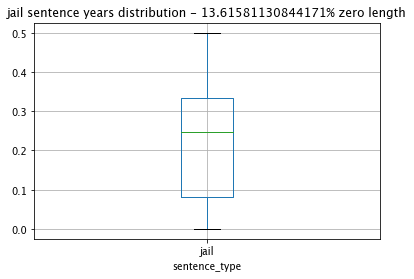

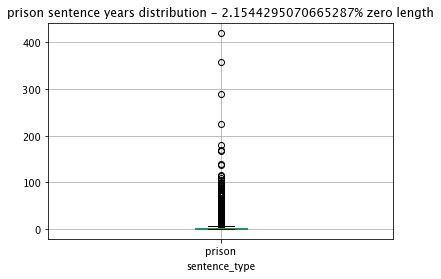

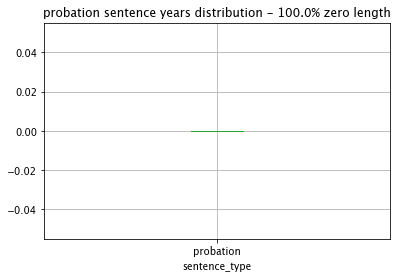

In [101]:
for sentence_type, sentence_group in va_sentence_df.groupby('sentence_type'):
    sentence_group.boxplot(column='effective_sentence_years', by='sentence_type')
    percent_zero_sentence = 100 * sum(sentence_group['effective_sentence_months'] == 0)/len(sentence_group)
    plt.suptitle('')
    plt.title(f'{sentence_type} sentence years distribution - {percent_zero_sentence}% zero length')

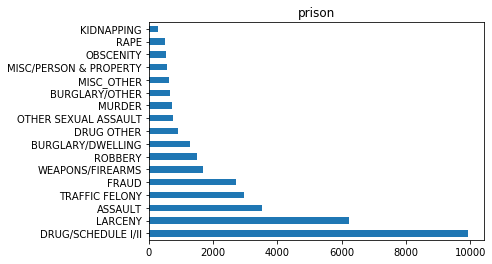

In [8]:
for sentence_type, sentence_group in va_sentence_df.groupby('sentence_type'):
    if sentence_type == 'probation':
        continue
    sentence_group['offense_group'].value_counts().plot.barh(ax=None)
    plt.title(sentence_type)

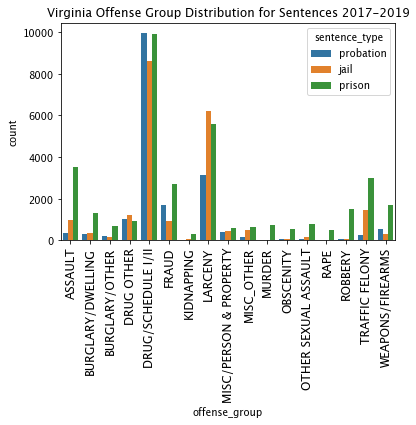

In [107]:
# Offense Group Options
offense_group_chart = sns.countplot(data=va_sentence_df, x='offense_group',hue='sentence_type')
offense_group_chart.set_title('Virginia Offense Group Distribution for Sentences 2017-2019')
chart_axis_label = offense_group_chart.set_xticklabels(offense_group_chart.get_xticklabels(), rotation=90, 
                                                       fontsize='large')

In [10]:
va_sentence_df[va_sentence_df['sentence_type'] == 'probation']['effective_sentence_months'].describe()

count    18180.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: effective_sentence_months, dtype: float64

In [11]:
va_sentence_df[va_sentence_df['sentence_type'] == 'jail']['effective_sentence_months'].describe()

count    21453.000000
mean         2.593934
std          2.089334
min          0.000000
25%          0.985626
50%          2.956879
75%          4.000000
max          6.000000
Name: effective_sentence_months, dtype: float64

In [12]:
va_sentence_df[va_sentence_df['sentence_type'] == 'prison']['effective_sentence_months'].describe()

count    34812.000000
mean        38.513931
std         84.777632
min          0.000000
25%         12.000000
50%         18.000000
75%         36.000000
max       5052.000000
Name: effective_sentence_months, dtype: float64

In [49]:
prison_df = va_sentence_df[va_sentence_df['sentence_type'] == 'prison']
prison_df

,offense_group,offense_code,off1_vcc,judge_id,year,effective_sentence_months,effective_sentence_years,life_sentence,offense_date,outflow_from,sentence_type
0,ASSAULT,ASL1316,ASL1316F6,0,2018.0,18.0,1.500000,0.0,5/20/2017,pretrial,prison
1,ASSAULT,ASL1316,ASL1316F6,0,2019.0,10.0,0.833333,0.0,4/25/2018,pretrial,prison
4,ASSAULT,ASL1316,ASL1316F6,10DB,2017.0,7.0,0.583333,0.0,12/25/2016,pretrial,prison
5,ASSAULT,ASL1316,ASL1316F6,10DB,2019.0,7.0,0.583333,0.0,11/17/2018,pretrial,prison
7,ASSAULT,ASL1316,ASL1316F6,10KW,2017.0,14.0,1.166667,0.0,12/11/2016,pretrial,prison
...,...,...,...,...,...,...,...,...,...,...,...
74312,WEAPONS/FIREARMS,WPN5298,WPN5298F6,9JS,2018.0,60.0,5.000000,0.0,8/29/2017,pretrial,prison
74313,WEAPONS/FIREARMS,WPN5298,WPN5298F6,9MM,2018.0,8.0,0.666667,0.0,6/1/2017,pretrial,prison
74314,WEAPONS/FIREARMS,WPN5298,WPN5298F6,9MM,2018.0,13.0,1.083333,0.0,6/27/2017,pretrial,prison
74315,WEAPONS/FIREARMS,WPN5298,WPN5298F6,9MM,2019.0,7.0,0.583333,0.0,11/30/2017,pretrial,prison


In [14]:
# look into offense groups that could potentially be merged based on similar sentence lengths
prison_df[['offense_group', 'offense_category', 'effective_sentence_months']]\
.groupby(['offense_group', 'offense_category'], as_index=False).agg(
{'effective_sentence_months': ['mean', 'count']}
).sort_values(by=['offense_category', ('effective_sentence_months', 'mean')])

offense_group offense_category effective_sentence_months      
                                                                 mean count
18              MISC_OTHER      non-violent                 13.536264   193
10                   FRAUD      non-violent                 14.023932  1968
30          TRAFFIC FELONY      non-violent                 15.732592  2185
14                 LARCENY      non-violent                 15.850912  3465
6               DRUG OTHER      non-violent                 18.338279   721
32        WEAPONS/FIREARMS      non-violent                 18.920968   874
4           BURGLARY/OTHER      non-violent                 19.342646   343
16  MISC/PERSON & PROPERTY      non-violent                 20.640469   425
8       DRUG/SCHEDULE I/II      non-violent                 24.607302  7691
2        BURGLARY/DWELLING      non-violent                 31.741674   742
0                  ASSAULT      non-violent                 32.531386  2328
24    OTHER SEXUAL ASSAULT      non-violent                 56.323428   620
12              KIDNAPPING      non-violent                 64.828196   202
28                 ROBBERY      non-violent                 68.685346  1003
22               OBSCENITY      non-violent                 73.976691   458
20                  MURDER      non-violent                209.279945   561
26                    RAPE      non-violent                229.738298   390
19              MISC_OTHER          violent                 13.684546   428
11                   FRAUD          violent                 20.539481   737
31          TRAFFIC FELONY          violent                 21.817058   787
15                 LARCENY          violent                 22.757904  2146
17  MISC/PERSON & PROPERTY          violent                 26.802096   153
7               DRUG OTHER          violent                 29.655357   189
33        WEAPONS/FIREARMS          violent                 31.478049   810
5           BURGLARY/OTHER          violent                 38.694761   330
9       DRUG/SCHEDULE I/II          violent                 47.542657  2231
1                  ASSAULT          violent                 51.914755  1202
3        BURGLARY/DWELLING          violent                 57.682254   543
25    OTHER SEXUAL ASSAULT          violent                105.359856   140
13              KIDNAPPING          violent                112.987500    80
29                 ROBBERY          violent                139.357964   487
23               OBSCENITY          violent                144.188889    90
21                  MURDER          violent                300.697562   167
27                    RAPE          violent                326.195122   123

In [15]:
va_sentence_df[va_sentence_df['offense_group'] == 'ROBBERY'].groupby(['sentence_type', 'offense_category']).count()

offense_group  offense_code  year  \
sentence_type offense_category                                      
jail          non-violent                  72            72    72   
              violent                       3             3     3   
prison        non-violent                1003          1003  1003   
              violent                     487           487   487   
probation     non-violent                  54            54    54   
              violent                       8             8     8   

                                offense_category_code  \
sentence_type offense_category                          
jail          non-violent                          72   
              violent                               3   
prison        non-violent                        1003   
              violent                             487   
probation     non-violent                          54   
              violent                               8   

                                effective_sentence_months  \
sentence_type offense_category                              
jail          non-violent                              72   
              violent                                   3   
prison        non-violent                            1003   
              violent                                 487   
probation     non-violent                              54   
              violent                                   8   

                                effective_sentence_years  outflow_from  
sentence_type offense_category                                          
jail          non-violent                             72            72  
              violent                                  3             3  
prison        non-violent                           1003          1003  
              violent                                487           487  
probation     non-violent                             54            54  
              violent                                  8             8

In [16]:
va_sentence_df.groupby(['sentence_type']).count()

,offense_group,offense_code,year,offense_category_code,effective_sentence_months,effective_sentence_years,outflow_from,offense_category
sentence_type,,,,,,,,
jail,21453,21453,21453,21453,21453,21453,21453,21453
prison,34812,34812,34812,34812,34812,34812,34812,34812
probation,18180,18180,18180,18180,18180,18180,18180,18180


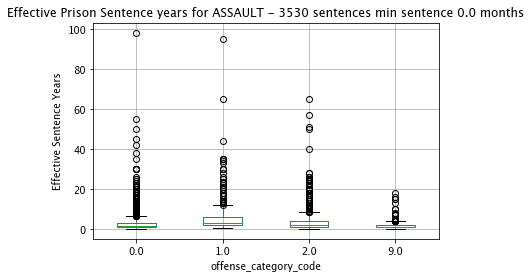

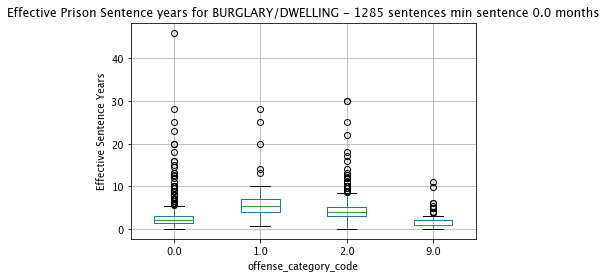

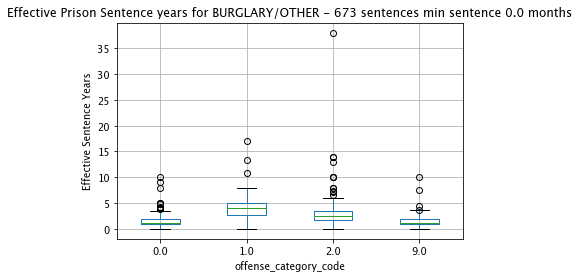

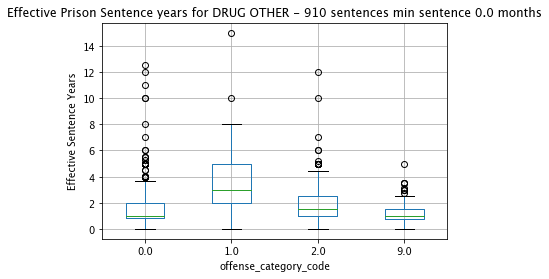

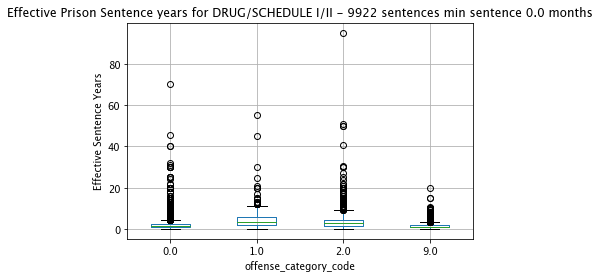

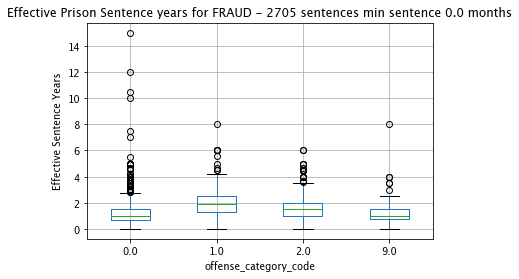

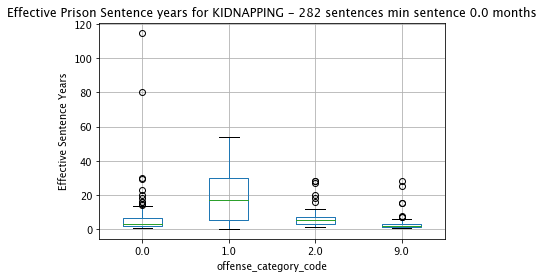

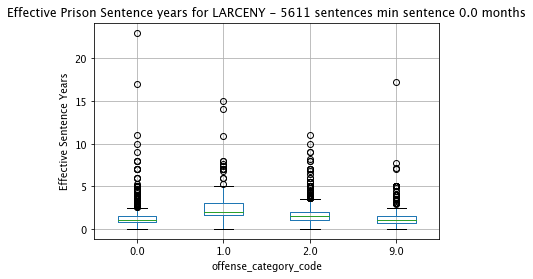

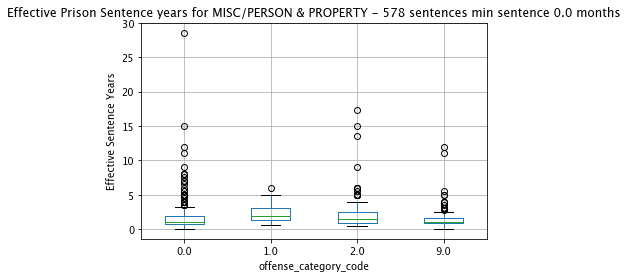

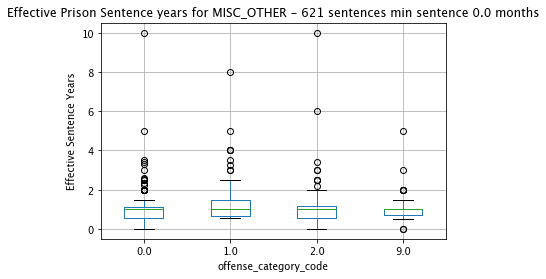

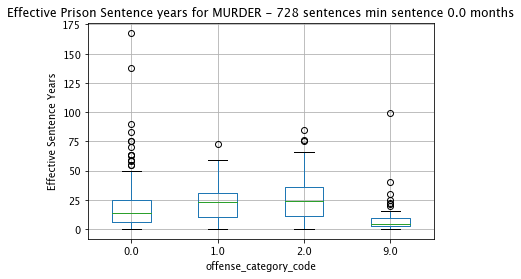

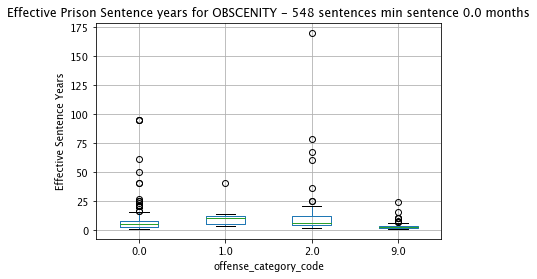

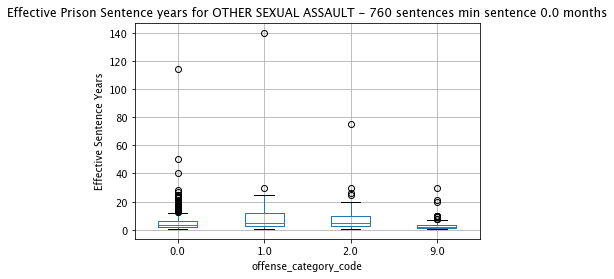

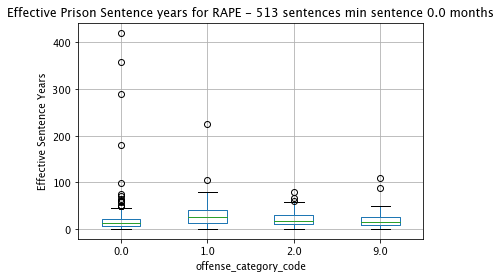

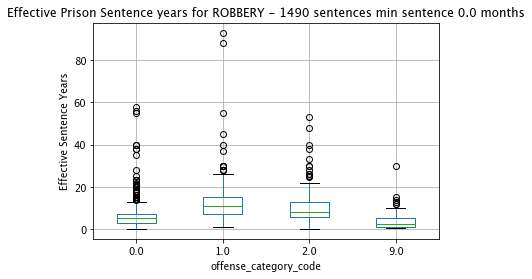

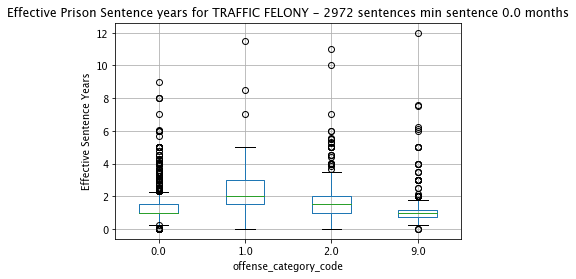

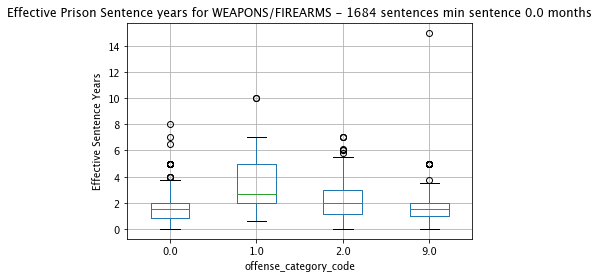

In [111]:
for offense_type, offense_group in prison_df.groupby('offense_group'):
    offense_group.boxplot(column='effective_sentence_years', by='offense_category_code')
    plt.title(f'Effective Prison Sentence years for {offense_type} - {len(offense_group)} sentences min sentence {min_sentence} months')
    plt.suptitle('')
    plt.ylabel('Effective Sentence Years')

1394


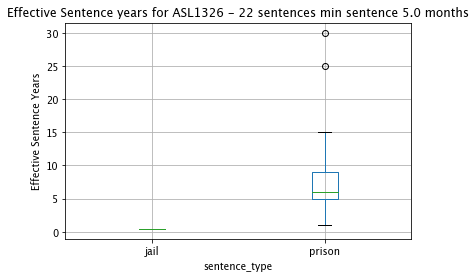

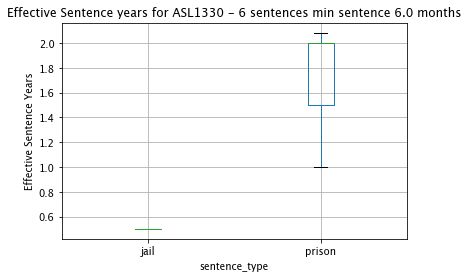

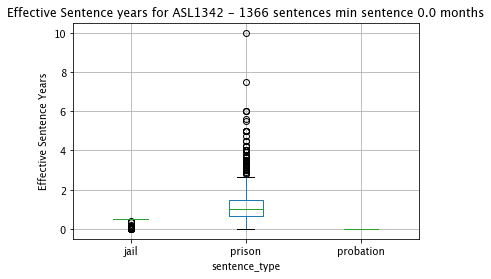

In [108]:
# Distribution of Offenses related to Assault on Law Enforcement 
law_enforcement_offenses = ['ASL1326', 'ASL1330', 'ASL1342']
law_enforcement_assault = va_sentence_df[va_sentence_df['offense_code'].isin(law_enforcement_offenses)]
print(len(law_enforcement_assault))
for offense_code, group in law_enforcement_assault.groupby('offense_code'):
    group.boxplot(column='effective_sentence_years', by='sentence_type')
    min_sentence = min(group['effective_sentence_months'])
    plt.title(f'Effective Sentence years for {offense_code} - {len(group)} sentences min sentence {min_sentence} months')
    plt.suptitle('')
    plt.ylabel('Effective Sentence Years')

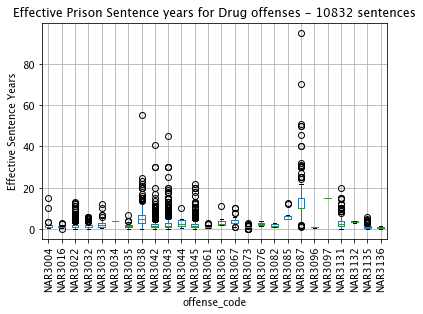

In [179]:
drug_offense_groups = ['DRUG/SCHEDULE I/II', 'DRUG OTHER']
drug_prison_offenses = va_sentence_df[(va_sentence_df['sentence_type'] == 'prison') 
                                      & (va_sentence_df['offense_group'].isin(drug_offense_groups))]
drug_prison_offenses.boxplot(column='effective_sentence_years', by='offense_code')
plt.title(f'Effective Prison Sentence years for Drug offenses - {len(drug_prison_offenses)} sentences')
plt.suptitle('')
plt.ylabel('Effective Sentence Years')
x_ticks = plt.xticks(rotation=90)

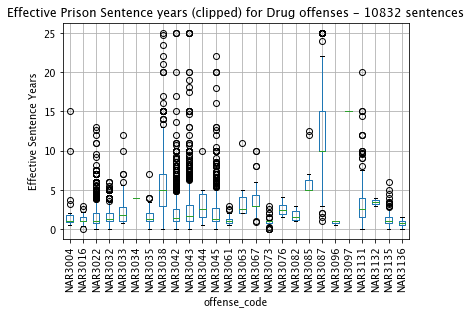

In [125]:
drug_offense_groups = ['DRUG/SCHEDULE I/II', 'DRUG OTHER']
va_sentence_df['effective_sentence_years_clipped'] = np.clip(va_sentence_df['effective_sentence_years'], 0, 25)
drug_prison_offenses = va_sentence_df[(va_sentence_df['sentence_type'] == 'prison') 
                                      & (va_sentence_df['offense_group'].isin(drug_offense_groups))]
drug_prison_offenses.boxplot(column='effective_sentence_years_clipped', by='offense_code')
plt.title(f'Effective Prison Sentence years (clipped) for Drug offenses - {len(drug_prison_offenses)} sentences')
plt.suptitle('')
plt.ylabel('Effective Sentence Years')
x_ticks = plt.xticks(rotation=90)

In [185]:
drug_offense_counts = pd.DataFrame()
for offense_code, group in drug_prison_offenses.groupby('offense_code'):
    min_sentence = min(group['effective_sentence_months'])
    num_min_sentence = sum(group['effective_sentence_months'] == min_sentence)
    drug_offense_counts.loc[offense_code, 'minimum_sentence'] = min_sentence
    drug_offense_counts.loc[offense_code, 'num_min_sentences'] = num_min_sentence
    drug_offense_counts.loc[offense_code, 'total_sentences'] = len(group)
drug_offense_counts.sort_values(by='total_sentences', ascending=False)

,minimum_sentence,num_min_sentences,total_sentences
NAR3022,0.0,128.0,2891.0
NAR3043,0.0,44.0,2095.0
NAR3042,0.0,65.0,2090.0
NAR3045,0.0,48.0,1373.0
NAR3038,0.0,1.0,703.0
NAR3032,0.0,9.0,365.0
NAR3135,0.0,12.0,282.0
NAR3131,0.0,4.0,282.0
NAR3087,12.0,1.0,184.0
NAR3035,0.0,6.0,184.0


In [120]:
print("Zero month prison sentences:", sum(drug_prison_offenses['effective_sentence_months'] == 0),
      100 * sum(drug_prison_offenses['effective_sentence_months'] == 0)/len(drug_prison_offenses))
print("Less than 1 year prison sentences:", sum(drug_prison_offenses['effective_sentence_months'] < 12),
      100 * sum(drug_prison_offenses['effective_sentence_months'] < 12)/len(drug_prison_offenses))

Zero month prison sentences: 326 3.0096011816838995
Less than 1 year prison sentences: 2489 22.97821270310192


In [132]:
prison_df.head()

,offense_group,offense_code,year,offense_category_code,effective_sentence_months,effective_sentence_years,sentence_type,offense_category
75,ASSAULT,ASL1316,2017.0,0.0,7.0,0.583333,prison,non-violent
76,ASSAULT,ASL1316,2017.0,0.0,7.0,0.583333,prison,non-violent
77,ASSAULT,ASL1316,2017.0,0.0,7.0,0.583333,prison,non-violent
78,ASSAULT,ASL1316,2017.0,0.0,7.0,0.583333,prison,non-violent
79,ASSAULT,ASL1316,2017.0,0.0,7.0,0.583333,prison,non-violent


In [137]:
vcc_groups = prison_df.groupby(['offense_group', 'offense_code'], 
                               as_index=False).agg({'offense_category_code': 'count',
                                                    'effective_sentence_years': ['min', 'max']})
vcc_groups.to_csv('va_offense_vcc_data.csv', index=False)
vcc_groups.head()

offense_group offense_code offense_category_code effective_sentence_years  \
                                             count                      min   
0       ASSAULT      ASL1316                   373                 0.566735   
1       ASSAULT      ASL1318                     3                 0.750000   
2       ASSAULT      ASL1319                     5                 2.000000   
3       ASSAULT      ASL1326                    21                 1.000000   
4       ASSAULT      ASL1327                     6                 1.000000   

         
    max  
0   8.0  
1   4.0  
2   9.0  
3  30.0  
4   3.5

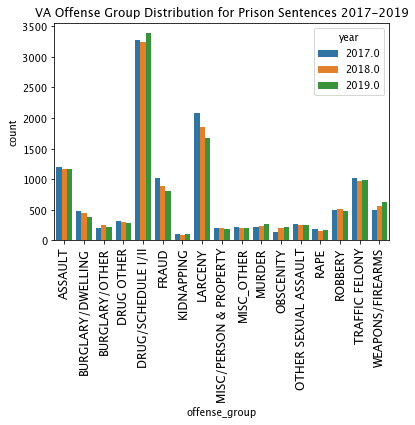

In [153]:
# Offense Group Options
offense_group_chart = sns.countplot(data=prison_df, x='offense_group',hue='year')
offense_group_chart.set_title('VA Offense Group Distribution for Prison Sentences 2017-2019')
chart_axis_label = offense_group_chart.set_xticklabels(offense_group_chart.get_xticklabels(), rotation=90, 
                                                       fontsize='large')

/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


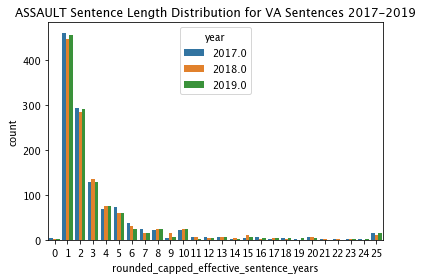

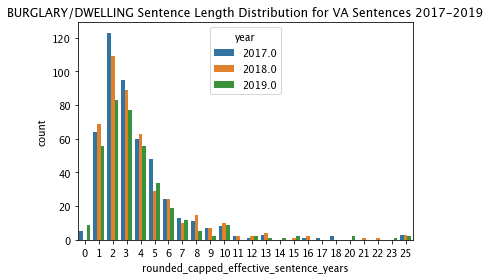

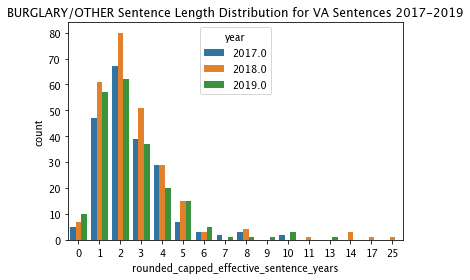

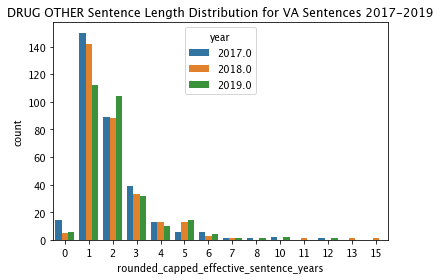

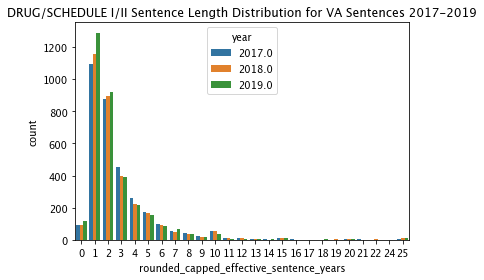

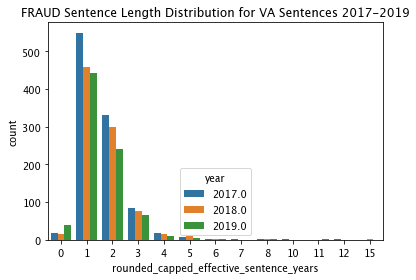

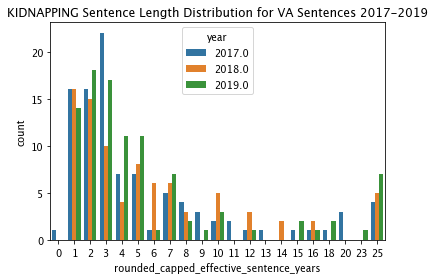

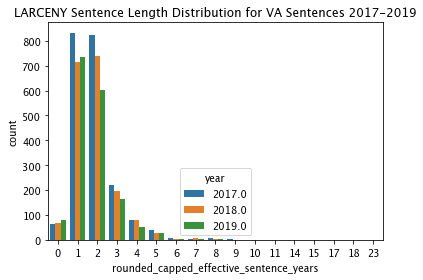

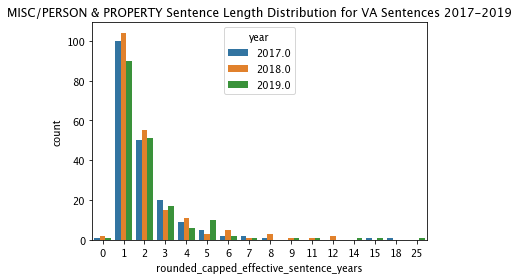

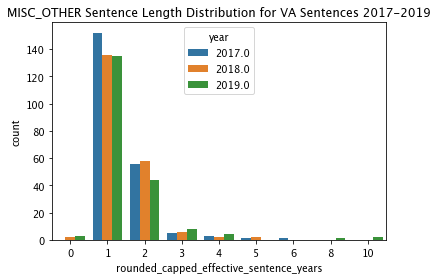

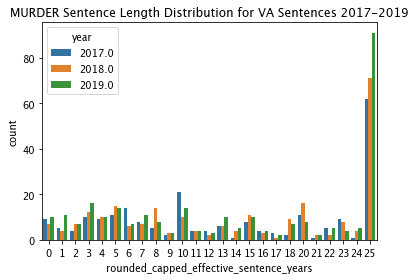

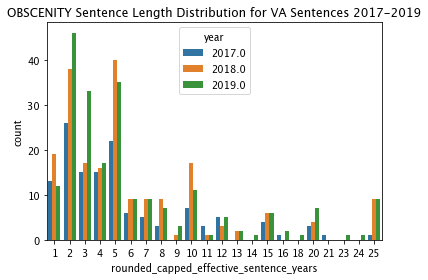

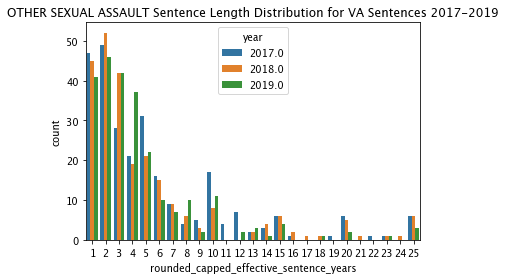

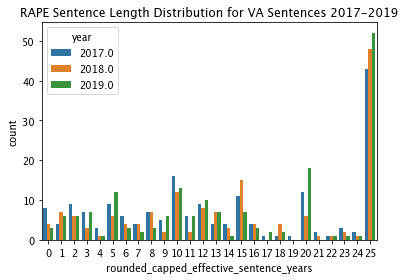

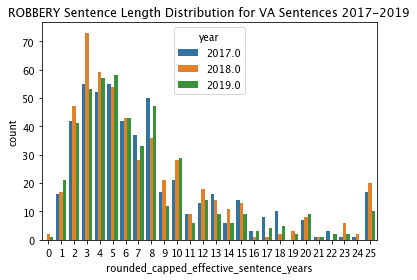

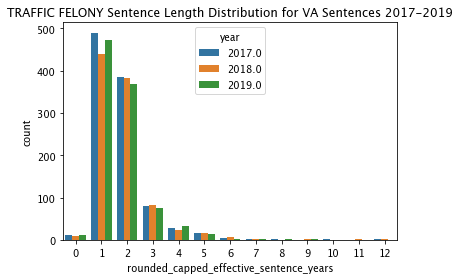

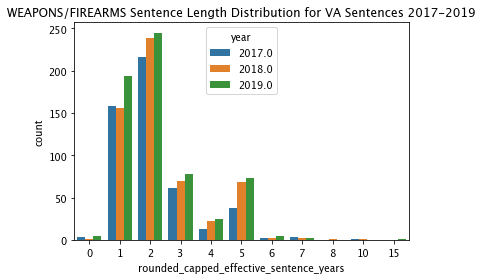

In [160]:
prison_df['rounded_capped_effective_sentence_years'] = \
    np.clip(np.ceil(prison_df['effective_sentence_years']), 0, 25).astype(int)
for index, (offense_group, group) in enumerate(prison_df.groupby('offense_group')):
    plt.figure(index)
    offense_group_chart = sns.countplot(data=group, x='rounded_capped_effective_sentence_years', hue='year')
    offense_group_chart.set_title(f'{offense_group} Sentence Length Distribution for VA Sentences 2017-2019')


/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/justine/.local/share/virtualenvs/recidiviz-research--

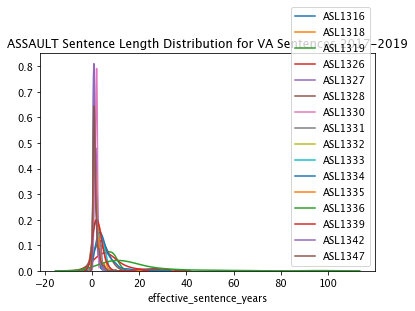

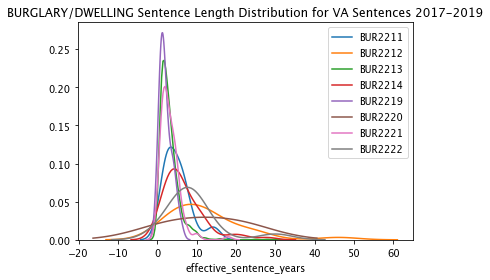

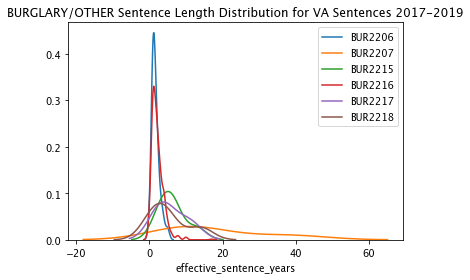

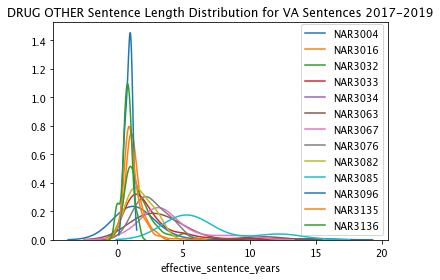

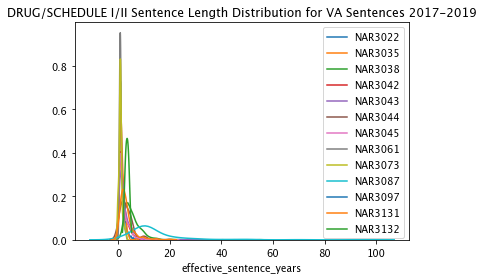

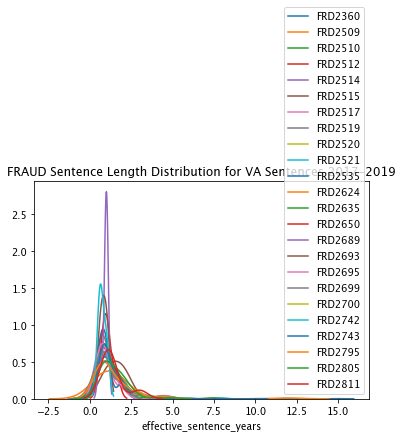

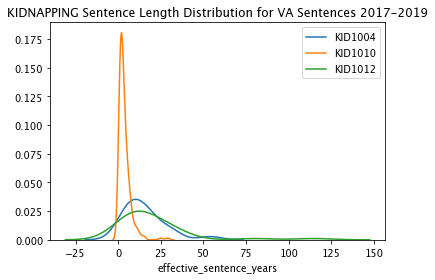

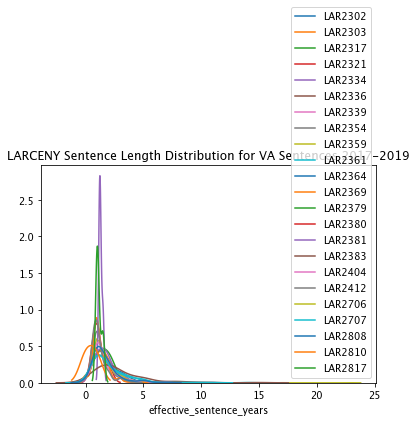

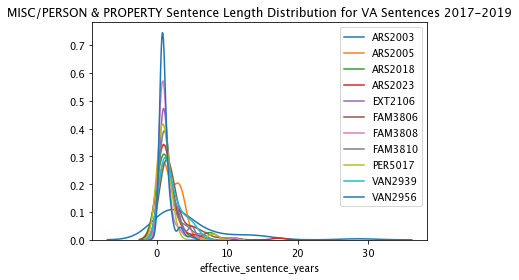

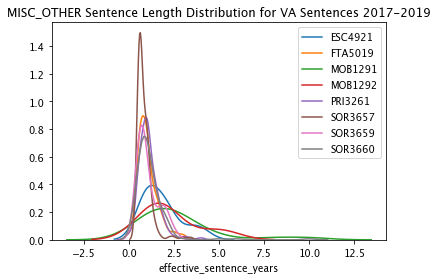

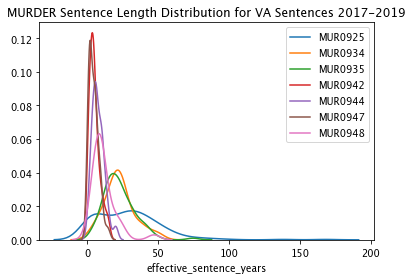

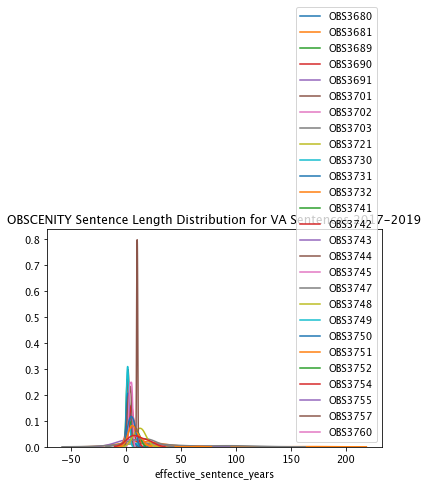

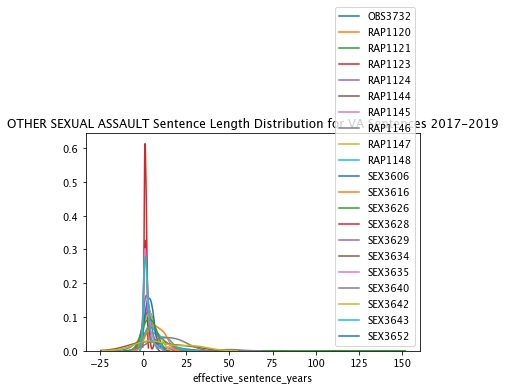

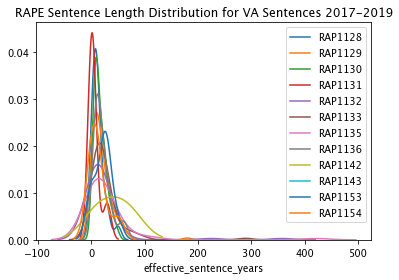

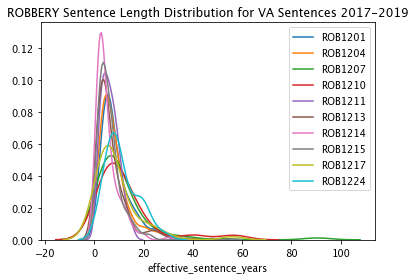

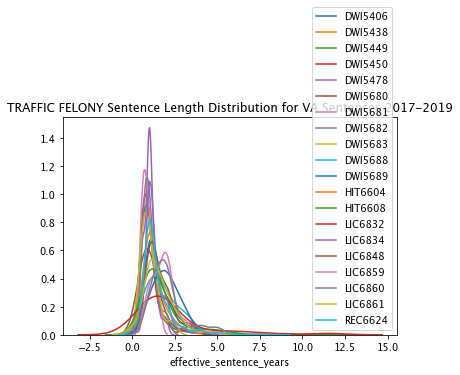

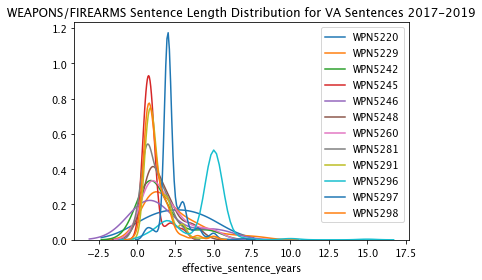

In [170]:
for index, (offense_group, group) in enumerate(prison_df.groupby('offense_group')):
    plt.figure(index)
    ax = None
    for vcc, vcc_group in group.groupby('offense_code'):
        ax = offense_group_chart = sns.distplot(vcc_group['effective_sentence_years'], label=vcc, ax=ax, hist=False)
    #plt.ylim([0, 1])
    offense_group_chart.set_title(f'{offense_group} Sentence Length Distribution for VA Sentences 2017-2019')


In [176]:
prison_df[prison_df['offense_code'] == 'NAR3073']['effective_sentence_years'].describe()

count    39.000000
mean      0.943922
std       0.628863
min       0.000000
25%       0.750000
50%       1.000000
75%       1.000000
max       3.000000
Name: effective_sentence_years, dtype: float64

In [177]:
prison_df[prison_df['offense_code'] == 'NAR3061']['effective_sentence_years'].describe()

count    58.000000
mean      1.120197
std       0.541325
min       0.583333
25%       0.750000
50%       1.000000
75%       1.333333
max       3.000000
Name: effective_sentence_years, dtype: float64

In [180]:
prison_df[prison_df['offense_code'] == 'NAR3087']['effective_sentence_years'].describe()

count    184.000000
mean      13.662286
std       11.310548
min        1.000000
25%       10.000000
50%       10.000000
75%       15.000000
max       95.000000
Name: effective_sentence_years, dtype: float64

21.73913043478261% below the Manditory Minimum


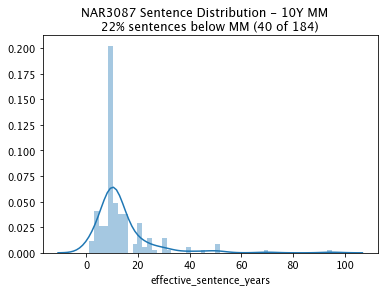

In [208]:
offense_code = 'NAR3087'
mm_years = 10
group = prison_df[prison_df['offense_code'] == offense_code]
percent_below = 100 * sum(group['effective_sentence_years'] < mm_years)/len(group)
print(f"{100 * sum(group['effective_sentence_years'] < mm_years)/len(group)}% below the Manditory Minimum")
ax = sns.distplot(group['effective_sentence_years'])
plt.suptitle(f'{offense_code} Sentence Distribution - {mm_years}Y MM')
plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

3.561253561253561% below the Manditory Minimum


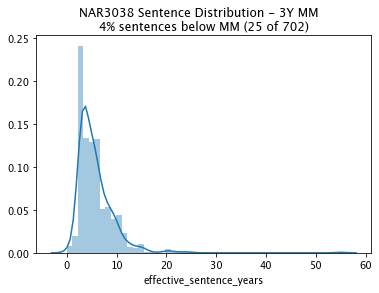

In [52]:
offense_code = 'NAR3038'
mm_years = 3
group = prison_df[prison_df['offense_code'] == offense_code]
percent_below = 100 * sum(group['effective_sentence_years'] < mm_years)/len(group)
print(f"{percent_below}% below the Manditory Minimum")
ax = sns.distplot(group['effective_sentence_years'])
title = plt.suptitle(f'{offense_code} Sentence Distribution - {mm_years}Y MM')
plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

0.0% below the Manditory Minimum


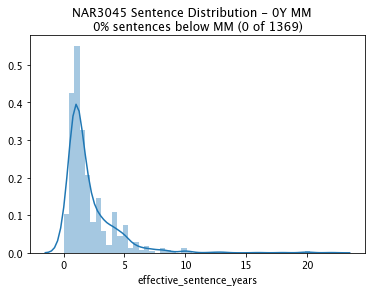

In [54]:
offense_code = 'NAR3045'
mm_years = 0
group = prison_df[prison_df['offense_code'] == offense_code]
percent_below = 100 * sum(group['effective_sentence_years'] < mm_years)/len(group)
print(f"{percent_below}% below the Manditory Minimum")
ax = sns.distplot(group['effective_sentence_years'])
title = plt.suptitle(f'{offense_code} Sentence Distribution - {mm_years}Y MM')
plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

0.0% below the Manditory Minimum


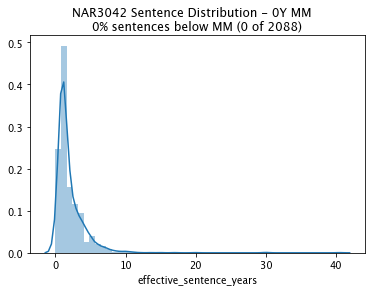

In [50]:
offense_code = 'NAR3042'
mm_years = 0
group = prison_df[prison_df['offense_code'] == offense_code]
percent_below = 100 * sum(group['effective_sentence_years'] < mm_years)/len(group)
print(f"{percent_below}% below the Manditory Minimum")
ax = sns.distplot(group['effective_sentence_years'])
title = plt.suptitle(f'{offense_code} Sentence Distribution - {mm_years}Y MM')
plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

15.625% below the Manditory Minimum


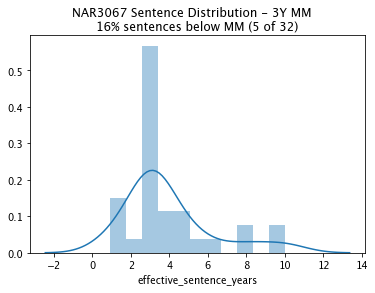

In [209]:
offense_code = 'NAR3067'
mm_years = 3
group = prison_df[prison_df['offense_code'] == offense_code]
percent_below = 100 * sum(group['effective_sentence_years'] < mm_years)/len(group)
print(f"{percent_below}% below the Manditory Minimum")
ax = sns.distplot(group['effective_sentence_years'])
title = plt.suptitle(f'{offense_code} Sentence Distribution - {mm_years}Y MM')
plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

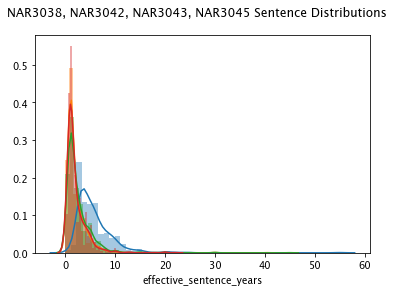

In [66]:
offense_codes = ['NAR3038', 
                 'NAR3042', 
                 'NAR3043', 
                 'NAR3045'
                ]
ax=None
for code in offense_codes: 
    group = prison_df[prison_df['offense_code'] == code]
    ax = sns.distplot(group['effective_sentence_years'], ax=ax)
title = plt.suptitle(f"{', '.join(offense_codes)} Sentence Distributions")
#plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

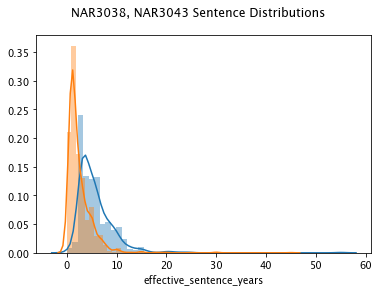

In [67]:
offense_codes = ['NAR3038', 
                 #'NAR3042', 
                 'NAR3043', 
                 #'NAR3045'
                ]
ax=None
for code in offense_codes: 
    group = prison_df[prison_df['offense_code'] == code]
    ax = sns.distplot(group['effective_sentence_years'], ax=ax)
title = plt.suptitle(f"{', '.join(offense_codes)} Sentence Distributions")
#plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

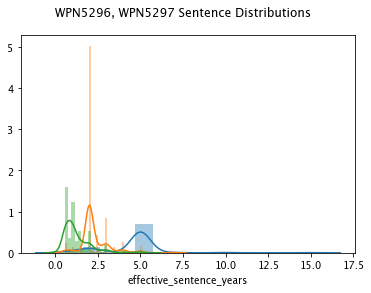

In [94]:
offense_codes = ['WPN5296', 
                 'WPN5297', 
                 #'WPN5291', 
                 #'WPN5298'
                ]
ax=None
for code in offense_codes: 
    group = prison_df[prison_df['offense_code'] == code]
    ax = sns.distplot(group['effective_sentence_years'], ax=ax)
title = plt.suptitle(f"{', '.join(offense_codes)} Sentence Distributions")

group_2 = prison_df[prison_df['offense_code'].isin(['WPN5291', 'WPN5298'])]
ax = sns.distplot(group_2['effective_sentence_years'], ax=ax)
#plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

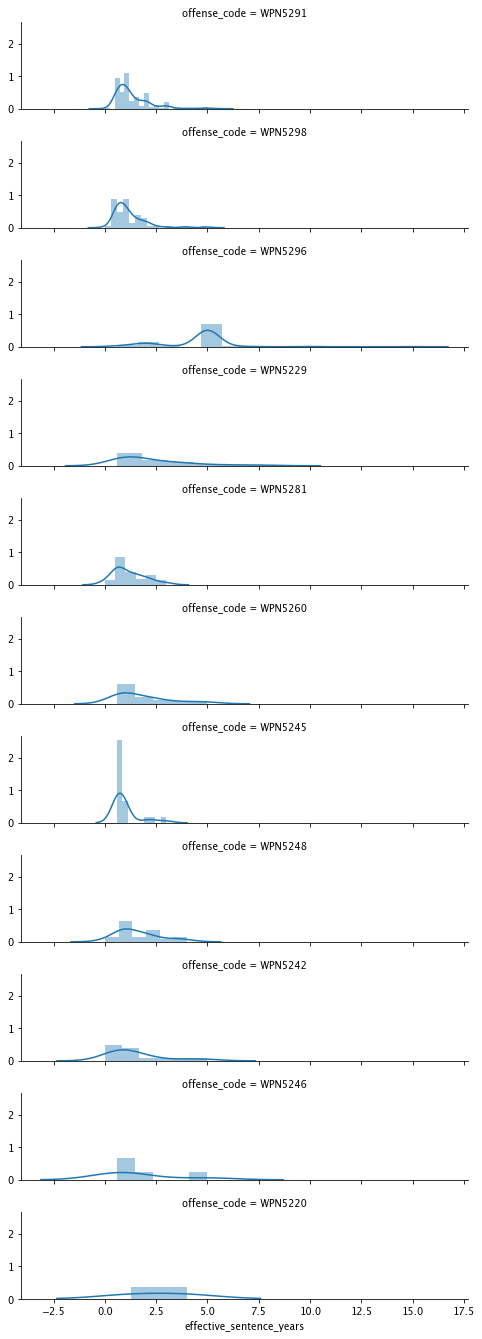

In [81]:
weapons_prison_sentences = prison_df[(prison_df['offense_group'] == 'WEAPONS/FIREARMS')
                                    & (prison_df['offense_code'] != 'WPN5297')]

ordered_codes = weapons_prison_sentences['offense_code'].value_counts().index
g = sns.FacetGrid(weapons_prison_sentences, row="offense_code", row_order=ordered_codes,
                  height=1.7, aspect=4,)
g.map(sns.distplot, "effective_sentence_years")

22.77227722772277% below the Manditory Minimum


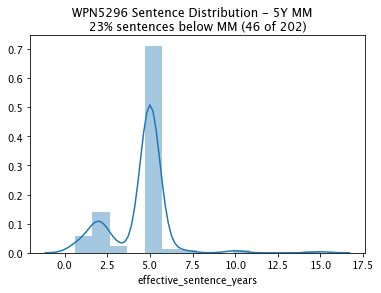

In [75]:
offense_code = 'WPN5296'
mm_years = 5
group = prison_df[prison_df['offense_code'] == offense_code]
percent_below = 100 * sum(group['effective_sentence_years'] < mm_years)/len(group)
print(f"{percent_below}% below the Manditory Minimum")
ax = sns.distplot(group['effective_sentence_years'])
title = plt.suptitle(f'{offense_code} Sentence Distribution - {mm_years}Y MM')
plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

7.06605222734255% below the Manditory Minimum


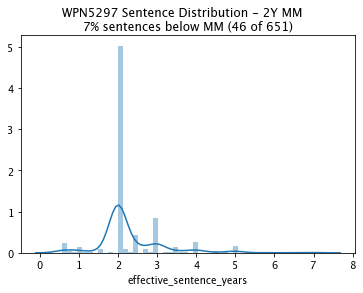

In [76]:
offense_code = 'WPN5297'
mm_years = 2
group = prison_df[prison_df['offense_code'] == offense_code]
percent_below = 100 * sum(group['effective_sentence_years'] < mm_years)/len(group)
print(f"{percent_below}% below the Manditory Minimum")
ax = sns.distplot(group['effective_sentence_years'])
title = plt.suptitle(f'{offense_code} Sentence Distribution - {mm_years}Y MM')
plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

In [91]:
agg_results = prison_df.groupby(['offense_group', 'offense_code'], as_index=False
                 ).agg({'off1_vcc': 'count', 'effective_sentence_years': ['min', 'max']}
                      ).sort_values(by=('effective_sentence_years', 'max'))


offense_group offense_code off1_vcc effective_sentence_years            
                                    count                      min         max
104         LARCENY      LAR2810        2                 0.000000    0.916667
203  TRAFFIC FELONY      DWI5438        1                 0.916667    0.916667
75            FRAUD      FRD2742        3                 0.583333    1.000000
93          LARCENY      LAR2364        1                 1.000000    1.000000
74            FRAUD      FRD2700        2                 1.000000    1.000000
..              ...          ...      ...                      ...         ...
133       OBSCENITY      OBS3681       26                 5.000000  170.000000
181            RAPE      RAP1129      132                 0.000000  180.000000
185            RAPE      RAP1133       94                 0.000000  289.000000
184            RAPE      RAP1132       70                 0.000000  357.000000
186            RAPE      RAP1135       59                 0.583333  421.000000

[234 rows x 5 columns]

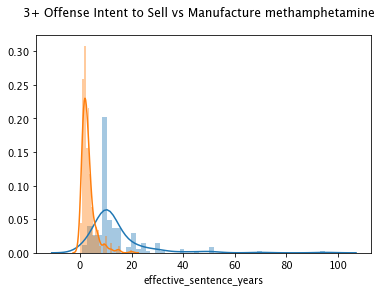

In [97]:
offense_codes = ['NAR3087', 
                 #'NAR3042', 
                 'NAR3131', 
                 #'NAR3045'
                ]
ax=None
for code in offense_codes: 
    group = prison_df[prison_df['offense_code'] == code]
    ax = sns.distplot(group['effective_sentence_years'], ax=ax)
title = plt.suptitle(f"3+ Offense Intent to Sell vs Manufacture methamphetamine")
#plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

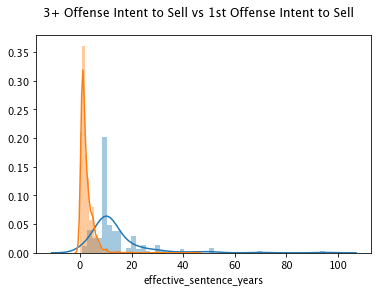

In [98]:
offense_codes = ['NAR3087', 
                 #'NAR3042', 
                 'NAR3043', 
                 #'NAR3045'
                ]
ax=None
for code in offense_codes: 
    group = prison_df[prison_df['offense_code'] == code]
    ax = sns.distplot(group['effective_sentence_years'], ax=ax)
title = plt.suptitle(f"3+ Offense Intent to Sell vs 1st Offense Intent to Sell")
#plt.title(f"{percent_below:.0f}% sentences below MM ({sum(group['effective_sentence_years'] < mm_years)} of {len(group)})")
ymin, ymax = ax.get_ylim()
#plt.vlines(x=mm_years, ymin=ymin, ymax=ymax, color='red')

In [100]:
prison_df[prison_df['effective_sentence_years'] > 10]['offense_group'].value_counts(dropna=False)

MURDER                    420
RAPE                      317
ROBBERY                   292
DRUG/SCHEDULE I/II        185
ASSAULT                   180
OTHER SEXUAL ASSAULT       85
OBSCENITY                  79
KIDNAPPING                 40
BURGLARY/DWELLING          40
MISC/PERSON & PROPERTY      9
LARCENY                     8
BURGLARY/OTHER              6
DRUG OTHER                  5
TRAFFIC FELONY              3
FRAUD                       3
WEAPONS/FIREARMS            1
Name: offense_group, dtype: int64

In [101]:
len(prison_df[prison_df['effective_sentence_years'] > 10])

1673